# ML in Cybersecurity: Task II

## Team
  * **Team name**:  *fill this in*
  * **Members**:  *fill this in. format: name1 (email1), name2 (email2), ...*


## Logistics
  * **Due date**: 25th Nov. 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Email the completed notebook to mlcysec_ws2022_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course forum to discuss.
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we ask you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results.

Whenever possible, please use tools like tables or figures to compare the different findings


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [3]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [ ]:
#
#
# ------- Your Code -------
#
#

# 1. Attacking an ML-model (30 points) 

In this section, we implement an attack ourselves. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from task 1.



## 1.1: Setting up the model and data (4 Points)

Load the MNIST data, as done in task 1. 

Re-use the model from task 1 here and train it until it achieves reasonable accuracy (>92%).

If you have the saved checkpoint from task 1, you can load it directly. But please compute here the test accuracy using this checkpoint.  

**Hint:** In order to save computation time for the rest of exercise, you might consider having a relatively small model here.

**Hint**: You might want to save the trained model to save time later.

In [4]:
#
#
# ------- Your Code -------
# Feel free to change this part depending on whether you would train a model or directly load a checkpoint 
#
#

# (1)load data 
# (2)define model
# (3)define loss, optimizer 
# (4)train (You can re-use the trained model from project1)
# (5)evaluate
# print('Epoch %d, Train acc: %f, Test acc: %f' % (epoch, train_acc, test_acc))
#Hyperparameters for the model

batch_size_train = 100 
batch_size_test = 100
n_epochs = 30
learning_rate = 2e-3
input_size=1
hidden_layers=[32,64,128]
drop_prob=0.3
num_classes=10
reg=0.001

#Initialise the weights
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

# Learning rate update functionality        
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr  
# Prepare the data
print("Loading dataset....")
transform = transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

# Loading the datasets
train_set = torchvision.datasets.MNIST(root='.', train=True, transform=transform, download=True)
train_set, valid_set = torch.utils.data.random_split(train_set, [50000, 10000])
test_set = torchvision.datasets.MNIST(root='.', train=False, transform=transform, download=True)

# Creating the train loader.
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size_train,
                                           shuffle=True)
# Creating the val loader.
val_loader = torch.utils.data.DataLoader(dataset=valid_set,
                                           batch_size=batch_size_train,
                                           shuffle=False)
# Creating the test loader.
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size_test,
                                          shuffle=False)

Loading dataset....


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
# Defining the model
class Net(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(Net, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(drop_prob)
        )
        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of second conv layer.
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output  # return x for visualization

In [ ]:


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Initialise the model
model = Net(input_size, hidden_layers, num_classes).to(device)
model.apply(weights_init)
running_loss = 0.0
loss_plot_y = []
loss_plot_x =[]
loss_plot_val_y = []
loss_plot_val_x =[]
lr = learning_rate
learning_rate_decay = 0.95
accuracy_plot = []
total_step = len(train_loader)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# For all the epochs.
for epoch in range(n_epochs):
        model.train()
        for (i, (images, labels)) in enumerate(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Loss calculation
            loss = criterion(outputs, labels)

            # zeroing the gradients
            optimizer.zero_grad()
            
            # Backpropagate the loss
            loss.backward()
            
            # Update the weights
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch
                        + 1, n_epochs, i + 1, total_step, loss.item()))
        loss_plot_y.append(running_loss / len(train_loader))
                #loss_plot_x.append(epoch * total_step + i)
        running_loss = 0.0
        loss_plot_x.append(epoch)
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        
        # Doing the validation step.
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for (images, labels) in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                (_, predicted) = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            loss_plot_val_y.append(running_loss / len(val_loader))
            accuracy_plot.append(100 * correct / total)

            print('Validation accuracy is: {} %'.format(100 * correct / total))
        running_loss=0.0

# Testing the model, although we only use the validation accuracy for selecting the best hyperparameters
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        (_, predicted) = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print ('Accuracy of the network on the test images: {} %'.format(
            100 * correct / total))

In [6]:
# Running the test loop for the best model and reporting test accuracy.
model = Net(input_size, hidden_layers, num_classes).to(device)
state_dict = torch.load('checkpoint.pth')
model.load_state_dict(state_dict)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        (_, predicted) = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print ('Accuracy of the network on the test images: {} %'.format(
            100 * correct / total))
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
# from google.colab import files
# files.download('checkpoint.pth')

Accuracy of the network on the test images: 99.11 %


## 1.2: Implementing the FGSM attack (7 Points)

We now want to attack the model trained in the previous step. We will start with the FGSM attack as a simple example. 

Please implement the FGSM attack mentioned in the lecture. 

More details: https://arxiv.org/pdf/1412.6572.pdf


In [7]:
#
#
# ------- Your Code -------
#
#

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [15]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

## 1.3: Adversarial sample set (7 Points)

* Please generate a dataset containing at least 1,000 adversarial examples using FGSM.

* Please vary the perturbation budget (3 variants) and generate 1,000 adversarial examples for each. 
    * **Hint**: you can choose epsilons within, e.g., = [.05, .1, .15, .2, .25, .3],  using MNIST pixel values in the interval       [0, 1]

* Compute the accuracy of each attack set. 

In [8]:
def test_perturbation(epsilon ):
  correct = 0
  total = 0
  adv_examples = []
  label_list =[]
  criterion = nn.CrossEntropyLoss()
  # Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
  for (images, labels) in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      images.requires_grad = True
      outputs = model(images)
      (_, predicted) = torch.max(outputs.data, 1)
      if predicted.item() != labels.item():
              continue

      # print("prediction is " + str(predicted.item()))
      # print("label is " + str(labels.item()))
      
      # Loss calculation
      loss = criterion(outputs, labels)

      # zeroing the gradients
      model.zero_grad()
      
      # Backpropagate the loss
      loss.backward()

      data_grad = images.grad.data

      # Call FGSM Attack
      perturbed_data = fgsm_attack(images, epsilon, data_grad)
      
      # Re-classify the perturbed image
      pert_output = model(perturbed_data)
      (_, perturb_predicted) = torch.max(pert_output.data, 1)
      # print(torch.eq(predicted,perturb_predicted))
      # print(perturb_predicted.item())
      # print(labels.item())
      
      if perturb_predicted.item() == labels.item():
              correct += 1
              # Special case for saving 0 epsilon examples
              if (epsilon == epsilon_list[0]) and labels.item() not in label_list and (len(label_list)<=10):
                  adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                  adv_examples.append( (labels.item(), perturb_predicted.item(), adv_ex))
                  label_list.append(labels.item())
      else:
              # Save some adv examples for visualization later
              if labels.item() not in label_list and (len(label_list)<=10):
                  adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                  adv_examples.append( (labels.item(), perturb_predicted.item(), adv_ex) )
                  label_list.append(labels.item())
      final_acc = correct/float(len(test_loader))
  adv_examples.sort(key=lambda x:x[0],reverse=False)
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return adv_examples,final_acc

In [16]:
epsilon_list = [0,0.05,0.15,0.30]
all_examples=[]
epsilon_run={}
epsilon_acc={}
for epsilon in epsilon_list:
  start_time = time.time()
  adv_examples, final_acc = test_perturbation(epsilon)
  all_examples.append(adv_examples)
  run_time = time.time() - start_time
  epsilon_run[epsilon] = run_time
  epsilon_acc[epsilon] = final_acc

Epsilon: 0	Test Accuracy = 9903 / 10000 = 0.9903
Epsilon: 0.05	Test Accuracy = 9656 / 10000 = 0.9656
Epsilon: 0.15	Test Accuracy = 7359 / 10000 = 0.7359
Epsilon: 0.3	Test Accuracy = 493 / 10000 = 0.0493


In [94]:
epsilon_list = [0,0.05,0.15,0.30]
#epsilon_list = [0.05]
all_examples=[]
for epsilon in epsilon_list:
  all_examples.append(test_perturbation(epsilon))

Epsilon: 0	Test Accuracy = 9903 / 10000 = 0.9903


## 1.4: Visualizing the results (7 Points)

* Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

* Please repeat the visualization for the three sets you have created 

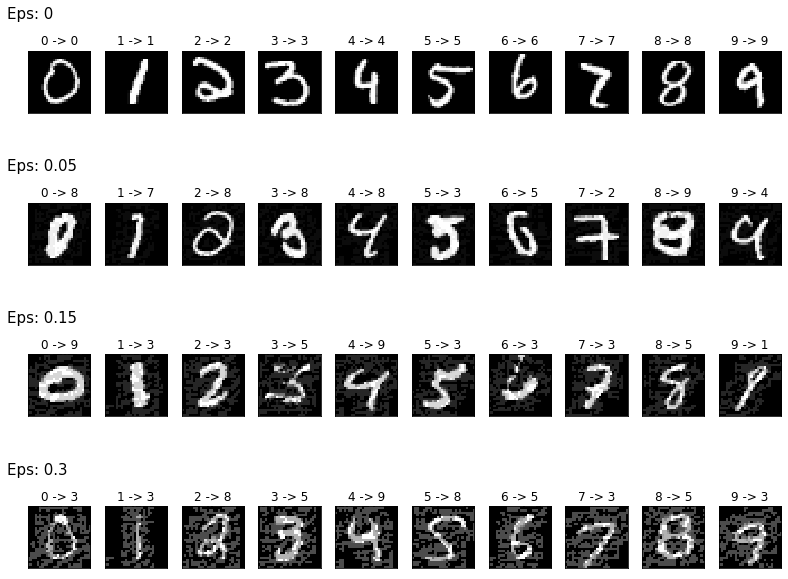

In [18]:
count=0
plt.figure(figsize=(11,11))
for i in range(len(all_examples)):
  adv_examples = all_examples[i]
  for j in range(len(adv_examples)):
          count+=1
          plt.subplot(5, 10, count)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
            plt.text(-10, -15, "Eps: {}".format(epsilon_list[i]), fontsize=15)
          a,b, ex = adv_examples[j]
          plt.title("{} -> {}".format(a, b))
          plt.imshow(ex, cmap="gray")
plt.tight_layout()                  

## 1.5: Analyzing the results (5 Points)

Please write a brief summary of your findings.  

* Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
* How about the computation cost of the attack? (you can report the time in second) 
* Does the attack require white-box access to the model?
* Feel free to report your results via tables or figures, and mention any other interesting observations 



**Your answers go here**


*   Attack doesn't always succeed especially for low perturbation budget. For example, perturbation budget of 0.05 gives a drop of 3% in accuracy (99% to 96.56%). We observe that the attack success rate is tightly coupled with the perturbation budget. More the epsilon value, higher will be the attack success rate. 
*   The computation costs of the attacks is given below in a table format.


*   The attacker requires white-box access to the model as he needs the gradients with respect to the input data, which can only be achieved if he has full access to the training weights and loss functions.
*   We have plotted a figure below which shows **'Accuracy vs Epsilon'**. We see that accuracy drops sharply after epsilon value of 0.15.





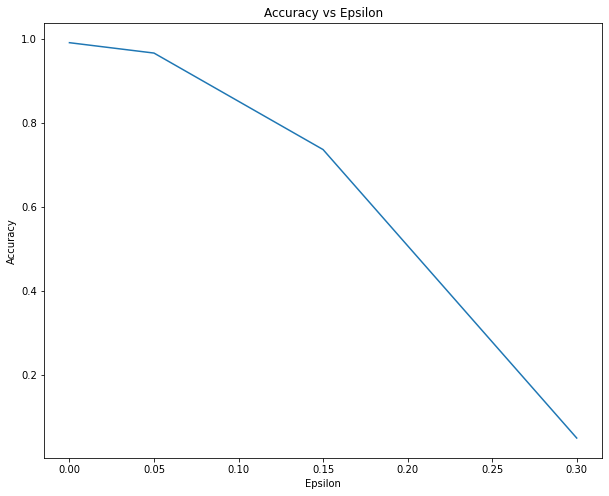

In [17]:
#
#
# ------- Your Code -------
#
#
plt.plot(list(epsilon_acc.keys()), list(epsilon_acc.values()))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [20]:
!pip install ipy_table
from ipy_table import *
temp = []
run_time_list = []

# convert the dictionary to a list
run_time_list.append(['Epsilon','Run-time'])
for key, value in epsilon_run.items():
    temp = [key,value]
    run_time_list.append(temp)


# create table with make_table
make_table(run_time_list)

Epsilon,Run-time
0,70.0339
0.0500,72.3422
0.1500,75.9098
0.3000,76.2443


# 2. Defending an ML model (35 points) 

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. 


## 2.1: Implementing the adversarial training defense (20 Points)

* We would like to ask you to implement the adversarial training defense (https://arxiv.org/pdf/1412.6572.pdf) mentioned in the lecture. 

* You can use the **FGSM adversarial training** method (i.e., train on FGSM examples). 

* You can also check the adversarial training implementation in other papers, e.g., http://proceedings.mlr.press/v97/pang19a/pang19a.pdf 

* Choose a certain **maximum perturbation budget** during training that is in the middle of the range you have experimented with before. 

* We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

**Hint:** You can save the checkpoint of the defended model as we would need it to for the third part of this exercise.


In [ ]:
#
#
# ------- Your Code -------
#
#
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# 12 minutes to run
# Initialise the model
model = Net(input_size, hidden_layers, num_classes).to(device)
model.apply(weights_init)
running_loss = 0.0
epsilon = 0.15
loss_plot_y = []
loss_plot_x =[]
loss_plot_val_y = []
loss_plot_val_x =[]
lr = learning_rate
learning_rate_decay = 0.95
accuracy_plot = []
total_step = len(train_loader)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# For all the epochs.
for epoch in range(n_epochs):
        model.train()
        for (i, (images, labels)) in enumerate(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            images.requires_grad = True
            # Forward pass
            outputs = model(images)
            
            # Loss calculation
            loss = criterion(outputs, labels)

            # zeroing the gradients
            optimizer.zero_grad()
            
            # Backpropagate the loss
            loss.backward()
            data_grad = images.grad.data
            # Update the weights
            optimizer.step()

            # Call FGSM Attack
            perturbed_data = fgsm_attack(images, epsilon, data_grad)
            outputs = model(perturbed_data)
            loss = criterion(outputs, labels)
            # zeroing the gradients
            optimizer.zero_grad()
            
            # Backpropagate the loss
            loss.backward()
            # Update the weights
            optimizer.step()
            images.grad.data.zero_()
            running_loss += loss.item()
            if (i + 1) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch
                        + 1, n_epochs, i + 1, total_step, loss.item()))
        loss_plot_y.append(running_loss / len(train_loader))
                #loss_plot_x.append(epoch * total_step + i)
        running_loss = 0.0
        loss_plot_x.append(epoch)
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        
        # # Doing the validation step.
        # model.eval()
        # with torch.no_grad():
        #     correct = 0
        #     total = 0
        #     for (images, labels) in val_loader:
        #         images = images.to(device)
        #         labels = labels.to(device)
        #         outputs = model(images)
        #         (_, predicted) = torch.max(outputs.data, 1)
        #         total += labels.size(0)
        #         correct += (predicted == labels).sum().item()
        #         loss = criterion(outputs, labels)
        #         running_loss += loss.item()
        #     loss_plot_val_y.append(running_loss / len(val_loader))
        #     accuracy_plot.append(100 * correct / total)

        #     print('Validation accuracy is: {} %'.format(100 * correct / total))
        # running_loss=0.0

Epoch [1/30], Step [50/500], Loss: 0.3993
Epoch [1/30], Step [100/500], Loss: 0.2663
Epoch [1/30], Step [150/500], Loss: 0.2333
Epoch [1/30], Step [200/500], Loss: 0.1662
Epoch [1/30], Step [250/500], Loss: 0.2094
Epoch [1/30], Step [300/500], Loss: 0.2039
Epoch [1/30], Step [350/500], Loss: 0.0920
Epoch [1/30], Step [400/500], Loss: 0.0794
Epoch [1/30], Step [450/500], Loss: 0.0842
Epoch [1/30], Step [500/500], Loss: 0.1305
Epoch [2/30], Step [50/500], Loss: 0.0920
Epoch [2/30], Step [100/500], Loss: 0.0700
Epoch [2/30], Step [150/500], Loss: 0.1171
Epoch [2/30], Step [200/500], Loss: 0.0520
Epoch [2/30], Step [250/500], Loss: 0.1234
Epoch [2/30], Step [300/500], Loss: 0.0711
Epoch [2/30], Step [350/500], Loss: 0.0667
Epoch [2/30], Step [400/500], Loss: 0.0898
Epoch [2/30], Step [450/500], Loss: 0.0668
Epoch [2/30], Step [500/500], Loss: 0.1090
Epoch [3/30], Step [50/500], Loss: 0.1229
Epoch [3/30], Step [100/500], Loss: 0.0402
Epoch [3/30], Step [150/500], Loss: 0.0745
Epoch [3/30], 

## 2.2: Evaluation (10 Points)

* Craft adversarial examples using the **defended** model. This entails at least 1,000 examples crafted via FGSM. 
    * Create one set using a budget that is **less than (within)** the one used in training.
    * Create another set using a budget that is **higher than** the one used in training. 
    * You can use two values of epsilons from question 1.3 
    
* Evaluate the **defended** model on these two adversarial examples sets. 


In [11]:
from google.colab import files
torch.save(model.state_dict(), 'checkpoint_adv.pth')
files.download('checkpoint_adv.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [14]:
#
#
# ------- Your Code -------
#
#
epsilon_list = [0,0.05,0.15,0.30]
all_examples=[]
epsilon_run={}
epsilon_acc={}
for epsilon in epsilon_list:
  start_time = time.time()
  adv_examples, final_acc = test_perturbation(epsilon)
  all_examples.append(adv_examples)
  run_time = time.time() - start_time
  epsilon_run[epsilon] = run_time
  epsilon_acc[epsilon] = final_acc
# print('Accuracy on the lower-budget adversarial samples (FGSM) %.2f'%acc_FGSM1)
# print('Accuracy on the lower-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend1)

# print('Accuracy on the higher-budget adversarial samples (FGSM) %.2f'%acc_FGSM2)
# print('Accuracy on the higher-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend2)

Epsilon: 0	Test Accuracy = 9860 / 10000 = 0.986
Epsilon: 0.05	Test Accuracy = 9666 / 10000 = 0.9666
Epsilon: 0.15	Test Accuracy = 7961 / 10000 = 0.7961
Epsilon: 0.3	Test Accuracy = 1292 / 10000 = 0.1292


## 2.3 Discussion (5 points)

* How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?
* How did the two sets differ?

**Your answers go here**

# 3: I-FGSM attack (35 points) 

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed. 
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack. 



## 3.1: Implementing the I-FGSM attack (10 Points)

**Hints**: 

* Your code should have an attack loop. At each step, the FGSM attack that you have implemented before is computed using a small step.
* After each step, you should perform a per-pixel clipping to make sure the image is in the allowed range, and that the perturbation is within budget.


In [ ]:
#
#
# ------- Your Code -------
#
#


## 3.2: Attack the undefended model (5 Points)

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison. 

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented. 

* Please compute the accuracy of the adversarial set on the **undefended** model. 

In [ ]:
#
#
# ------- Your Code -------
#
#


### 3.2.1: Findings and comparison with FGSM (8 points)

* Please report your findings. How successful was the attack? 

* What do you expect when increasing the number of steps? (you can experiment with different parameters of the attack and report your findings) 

* Compare with the basic FGSM. Using the same perturbation budget and using the same model, which attack is more successful? Why do you think this is the case? What about the computation time?

* Feel free to report any interesting observations. 

**Your answers go here**

## 3.3: Attack the defended model (5 poinst) 

* In the previous question, we attacked the **undefended model**. 

* Now, we want to explore how successful the previous implemented defense (FGSM adversarial training) is againts this new attack. (we will not implement a new defense here, we will be reusing your previous checkpoint of the **defended model**)


* Use the **defended model** to create one set of adversarial examples. Use a perturbation budget from Question **2.2** for comparison.  

In [ ]:
#
#
# ------- Your Code -------
#
#

### 3.3.1: Discussion (7 points) 
* Please report your results. How successful was the attack on the defended model? 
* Compare it with the success of the FGSM attack on the defended model. What do you observe? How do you interpret the difference? 
* How do you think you can improve the defense against I-FGSM attack?


* Feel free to state any interesting findings you encountered during this project.

**Your answers go here**